# Generate training data for exercises
 >__Created__:  2020


In [8]:
import os, sys
import numpy as np
import joblib as jb
import scipy.stats as st 
import pandas as pd
# standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

import corner
%matplotlib inline

In [9]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)

In [10]:
def generate(mu, cov, N, target):
    d  = st.multivariate_normal.rvs(mu, cov, N)
    X  = [x for x, y in d]
    Y  = [y for x, y in d]
    T  = np.zeros(N) if target < 0.5 else np.ones(N)
    df = pd.DataFrame({'target': T, 'x': X, 'y': Y})
    return df

In [11]:
N   = 15000
mu  = np.array([-1.0, 1.0])
cov = np.array([[ 0.4, 0.0],
                [ 0.0, 0.4]])
b1  = generate(mu, cov, N, 0)

In [12]:
N   = 15000
mu  = np.array([1.0,-1.0])
cov = np.array([[ 0.4, 0.0],
                [ 0.0, 0.4]])
b2  = generate(mu, cov, N, 0)
bkg = b1.append(b2)

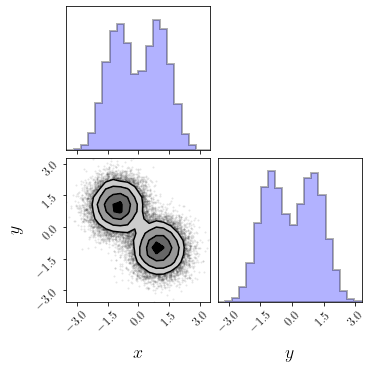

In [13]:
inputs = ['x', 'y']
labels = ['$x$', '$y$']
fig = corner.corner(bkg[inputs], 
                    labels=labels,
                    fill_contours=True,
                    hist_kwargs={'histtype': 'stepfilled',
                                 'linewidth': 2,
                                 'edgecolor': 'black', 
                                 'facecolor': 'blue', 
                                 'alpha': 0.3})
fig.savefig('fig_bkg.pdf')

In [14]:
N   = 15000
mu  = np.array([-1.0, -1.0])
cov = np.array([[ 0.4, 0.0],
                [ 0.0, 0.4]])
s1  = generate(mu, cov, N, 1)

In [15]:
N   = 15000
mu  = np.array([1.0, 1.0])
cov = np.array([[ 0.4, 0.0],
                [ 0.0, 0.4]])
s2  = generate(mu, cov, N, 1)
sig = s1.append(s2)

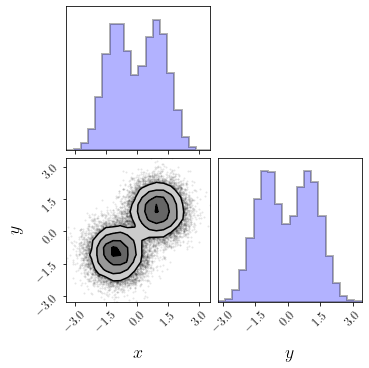

In [16]:
fig = corner.corner(sig[inputs], 
                    labels=labels,
                    fill_contours=True,
                    hist_kwargs={'histtype': 'stepfilled',
                                 'linewidth': 2,
                                 'edgecolor': 'black', 
                                 'facecolor': 'blue', 
                                 'alpha': 0.3})
fig.savefig('fig_sig.pdf')

In [17]:
data = sig.append(bkg)

In [18]:
len(data)

60000

In [19]:
df = data.sample(frac=1).reset_index(drop=True)
jb.dump(df, 'data_01.db')
df[:10]

,target,x,y
0,0.0,1.108128,-0.824089
1,1.0,-1.516782,-0.730723
2,1.0,1.597431,0.360849
3,1.0,0.434324,1.547732
4,1.0,1.432081,2.198656
5,0.0,-0.397923,-0.446679
6,0.0,-0.854507,1.366339
7,0.0,-1.702364,1.723362
8,1.0,0.261541,1.012989
9,0.0,0.421314,-1.552455


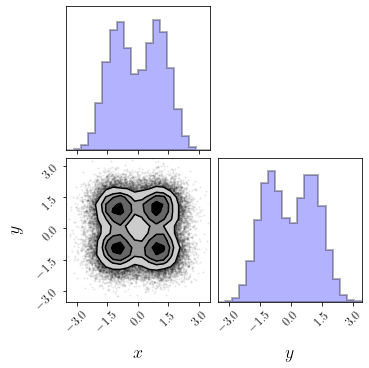

In [20]:
fig = corner.corner(df[inputs][:50000], 
                    labels=labels,
                    fill_contours=True,
                    hist_kwargs={'histtype': 'stepfilled',
                                 'linewidth': 2,
                                 'edgecolor': 'black', 
                                 'facecolor': 'blue', 
                                 'alpha': 0.3})
fig.savefig('fig_data.pdf')

### generate 1D data

In [21]:
N  = 50000
x  = np.random.uniform(-1, 1, N)
x[:5]

array([-0.34452896,  0.68916876,  0.75271944,  0.68368277, -0.37684452])

In [22]:
mu = 3 * np.exp(-x/2) * np.sin(10*x)**2 + 2*np.cos(6*x)
mu[:5]

array([-0.63375704, -0.39708805,  1.45725852, -0.55698478, -0.02715916])

In [23]:
def plot_1d(x, y):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.scatter(x, y)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)

    plt.show()

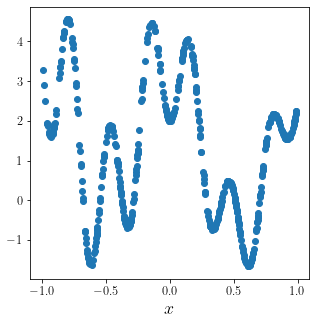

In [24]:
M = 500
plot_1d(x[:M], mu[:M])

In [25]:
df = pd.DataFrame({'target': mu, 'x': x})
df[:5]

,target,x
0,-0.633757,-0.344529
1,-0.397088,0.689169
2,1.457259,0.752719
3,-0.556985,0.683683
4,-0.027159,-0.376845


In [26]:
jb.dump(df, 'data_02.db')

['data_02.db']